# **Analysis of the influence of aquaculture pond construction on mangrove forests in Asian countries.**

## Introduction
Almost one third of the world's mangrove forests have been lost due to deforestation in the last 50 years (Alongi, 2002; Barbier, 2014). Along with coastal development, another major cause of global mangrove deforestation is the development of shrimp farms to support a booming export fishing industry (Barbier and Cox, 2004; Hamilton, 2020; Richards and Friess, 2016), with global demand for shrimp continuing to rise (Anderson et al., 2019). A study by Hamilton (2013) found that 51.9% of the original mangrove areas have been deforested between the 1970s and after 2004, with commercial aquaculture accounting for 28% of the total mangrove loss in eight countries: Indonesia, Brazil, Bangladesh, India, Thailand, Vietnam, Ecuador and China.

This notebook series studies the influence of aquaculture pond construction on mangrove forests through spatial analysis of two datasets: Aquaculture dynamics (Ottinger et al., 2021) and the Global Mangrove Watch version 3 (Bunting et al., 2018; Bunting, Rosenqvist, Hilarides, Lucas, & Thomas, 2022; Bunting, Rosenqvist, Hilarides, Lucas, Thomas, et al., 2022).

The general objective is to look for a relationship between the activation or construction of aquaculture ponds and the loss of mangrove forest extent. For this purpose, several notebooks were made for the different steps in the analysis process:


1.   DataPreparation: The datasets are divided by countries in Asia and the layers are organised in separate folders.
2.   DataAnalysis: We proceed to analyse the relationship between both datasets using geoprocessing tools and working with dataframes.
3.   MangroveChangeAnalysis: Only the Global Mangrove Watch dataset is analysed and an analysis of the dynamics within Asia is made.
4.   GraphicOutput: The results of the analysis are visualised for interpretation and understanding.
5.   HexagonMangrove: Mapping the cumulative mangrove forest loss from 1996 to 2020 in the ten countries with the highest mangrove loss in Asia.
6.   HexagonPonds: Mapping cumulative mangrove loss due to pond construction from 1996 to 2019.
This code is for create a map of loss in mangrove forest in Asia using hexagons

# Notebook 5: Mapping of mangrove Loss by aquaculture  in Asia

This notebook maintains the same objectives as the previous analyses but adds a spatial component. Maps are created that illustrate the spatial distribution of mangrove losses due to the activation or construction of aquaculture ponds. For this we will use the resulting layers from notebooks 1 and 2. The layer of the hexagons cut out for each country and the layer of the ponds with the columns of the analysis results.

First we are going to define all the libraries we are going to use

In [51]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar


Then we open the layers necessary for the analysis and create the geodataframes

In [52]:
# Read the GeoPackage file containing ponds and mangroves data for Myanmar and store it in a GeoDataFrame named 'ponds'.
ponds = gpd.read_file('Countries/Vietnam/Viet_ponds_mangroves.gpkg')


# Read the GeoPackage file containing hexagons for Myanmar, convert its CRS to EPSG:3857, and store it in a GeoDataFrame named 'hexagons'.
hexagons = gpd.read_file('Countries/Vietnam/Viet_hex.gpkg').to_crs(3857)

## 5.1 Spatial Union
Then we perform a spatial join operation to create a new column in the hexagons layer with the sum of the "area_difference" column within each hexagon. The area will be converted to square kilometres for better representation on the map. This layer is the one we will use to make the maps. 

In [53]:
# Add a new column 'hex_id' to 'hexagons' GeoDataFrame,
# which stores the index of each row. This will be used for aggregation later.
hexagons['hex_id'] = hexagons.index

# Perform a spatial join between 'hexagons' and 'ponds'.
# This will identify which hexagons intersect with which ponds.
joined = gpd.sjoin(hexagons, ponds, how="inner", predicate="intersects")

# Group the 'joined' GeoDataFrame by 'hex_id' and aggregate the 'area_difference' values.
# This will give the sum of 'area_difference' for each hexagon.
aggregated = joined.groupby('hex_id').area_difference.sum().reset_index()

# Merge the aggregated data back to the original 'hexagons' GeoDataFrame.
# This will add the summed 'area_difference' for each hexagon.
# Hexagons without any intersecting ponds will have 'area_difference' set to 0.
final_hexagons = hexagons.merge(aggregated, on='hex_id', how='left').fillna(0)

# Filter out hexagons with 'area_difference' equal to 0.
# This will create a new GeoDataFrame 'filtered_hexagons' containing only the hexagons we're interested in.
final_hexagons = final_hexagons[final_hexagons['area_difference'] != 0]

# Convert the 'area_difference' values from square meters to square kilometers.
# This will make the data more interpretable.
final_hexagons['area_difference'] = final_hexagons['area_difference'] / 1_000_000

## 5.2 Map creation

Next we create a map of mangrove loss due to the activation of the ponds. For this we will use the same geopanda package.

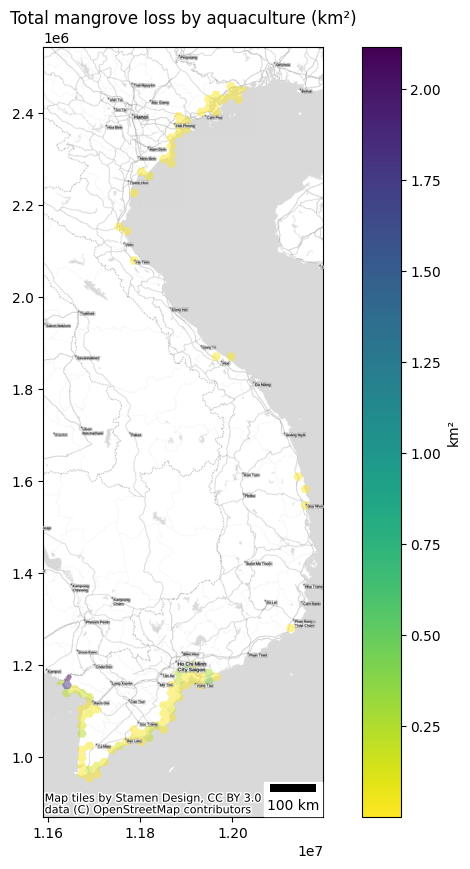

In [54]:
# Assuming filtered_hexagons is already defined
# Plot the 'final_hexagons' GeoDataFrame
ax = final_hexagons.plot(
    column='area_difference',  # Color hexagons based on 'area_difference'
    cmap='viridis_r',  # Use a reversed viridis colormap
    figsize=(10, 10),  # Set figure size
    alpha=0.5,  # Set transparency
    edgecolor=None,  # No edge color for hexagons
    legend=True,  # Show color legend
    legend_kwds={
        'orientation': "vertical"  # Vertical orientation for color legend
    }
)
# Set the title of the map
ax.set_title("Total mangrove loss by aquaculture (km²)")

# Get the colorbar from the axes and set its label
colorbar = ax.get_figure().get_axes()[1]  # The colorbar is assumed to be the second axes
colorbar.set_ylabel('km²')

# Add a basemap using contextily (cx)
cx.add_basemap(ax, crs=final_hexagons.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, crs=final_hexagons.crs.to_string(), source=cx.providers.Stamen.TonerLabels)

# Add a scale bar to the map
scalebar = ScaleBar(1, units='m', location='lower right', scale_loc='bottom')  
ax.add_artist(scalebar)

# Save the figure to a JPG file with 300 DPI
plt.savefig('viet_hexagons_map.jpg', dpi=300, format='jpg')

# Display the plot
plt.show()



These are the maps of the three countries with the highest losses according to our analysis.

Finally, we have the possibility to export the hexagons in gpkg.

In [55]:
# Optionally, save to a new GeoPackage
#final_hexagons.to_file("Countries/Myanmar/Myan_hex.gpkg", driver="GPKG")